In [1]:
%matplotlib inline

import xarray as xr
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
from scipy.io import savemat, loadmat

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh

from tonic.io import read_configobj

from da_utils import (load_nc_and_concat_var_years, setup_output_dirs,
                      da_3D_to_2D_for_SMART, da_2D_to_3D_from_SMART, rmse,
                      to_netcdf_forcing_file_compress)

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/civil/hydro/ymao/anacond

In [62]:
# ============================================================ #
# Process command line arguments
# Read config file
# ============================================================ #
cfg = read_configobj(
    '/civil/hydro/ymao/data_assim/control/run_SMART/ArkRed/GPM_SMAP_36km/'
    'EnKS.lambda_0.5.Q9.3hourly.no_split_grid.window_1.cfg')
# cfg = read_configobj(
#     '/civil/hydro/ymao/data_assim/control/run_SMART/ArkRed/'
#     'ArkRed.EnKS.tune_to_truth.Q9.3hourly.cfg')
# cfg = read_configobj(
#     '/civil/hydro/ymao/data_assim/control/run_SMART/small_basins/arkansas/'
#     'EnKS.tune_to_truth.prec_1.Q1.3hourly.cfg')

In [63]:
# ============================================================ #
# Check wether PLOT section is in the cfg file
# ============================================================ #
if 'PLOT' in cfg:
    pass
else:
    raise ValueError('Must have [PLOT] section in the cfg file to plot'
                     'SMART-corrected rainfall results!')

In [64]:
# ============================================================ #
# Process some input variables
# ============================================================ #
start_time = pd.to_datetime(cfg['SMART_RUN']['start_time'])
end_time = pd.to_datetime(cfg['SMART_RUN']['end_time'])
start_year = start_time.year
end_year = end_time.year
time_step = cfg['SMART_RUN']['time_step']  # [hour]
window_size = cfg['SMART_RUN']['window_size']  # number of timesteps

In [65]:
# ============================================================ #
# Set up output directory
# ============================================================ #
output_dir = setup_output_dirs(
                    os.path.join(cfg['CONTROL']['root_dir'],
                                 cfg['OUTPUT']['output_basedir']),
                    mkdirs=['plots'])['plots']

output_subdir_maps = setup_output_dirs(
                            output_dir,
                            mkdirs=['maps'])['maps']
output_subdir_ts = setup_output_dirs(
                            output_dir,
                            mkdirs=['time_series'])['time_series']
output_subdir_data = setup_output_dirs(
                            output_dir,
                            mkdirs=['data'])['data']

In [66]:
# ============================================================ #
# Load data
# ============================================================ #
print('Load data...')

# --- Load origigal precip --- #
print('\tOriginal precip')
da_prec_orig = load_nc_and_concat_var_years(
    basepath=os.path.join(
        cfg['CONTROL']['root_dir'],
        cfg['PLOT']['orig_prec_basepath']),
    start_year=start_year,
    end_year=end_year,
    dict_vars={'prec_orig': cfg['PLOT']['orig_prec_varname']})\
        ['prec_orig'].sel(time=slice(start_time, end_time))
    
# --- Load truth precip --- #
print('\tTrue precip')
da_prec_truth = load_nc_and_concat_var_years(
    basepath=os.path.join(
        cfg['CONTROL']['root_dir'],
        cfg['PLOT']['truth_prec_basepath']),
    start_year=start_year,
    end_year=end_year,
    dict_vars={'prec_truth': cfg['PLOT']['truth_prec_varname']})\
        ['prec_truth'].sel(time=slice(start_time, end_time))

Load data...
	Original precip
	True precip


In [67]:
# --- Load SMART-corrected precip --- #
# Identify which SMART postprocessed directory to read from
if cfg['PLOT']['smart_output_from'] == 'post':
    smart_outdir = os.path.join(
        cfg['CONTROL']['root_dir'], cfg['OUTPUT']['output_basedir'], 'post_SMART')
elif cfg['PLOT']['smart_output_from'] == 'spatial_downscale':
    smart_outdir = os.path.join(
        cfg['CONTROL']['root_dir'], cfg['OUTPUT']['output_basedir'], 'post_spatial_downscaled')
elif cfg['PLOT']['smart_output_from'] == 'remap':
    smart_outdir = os.path.join(
        cfg['CONTROL']['root_dir'], cfg['OUTPUT']['output_basedir'], 'post_final_remapped')
# Load deterministic result
print('\tSMART-corrected, deterministic...')
da_prec_corrected = load_nc_and_concat_var_years(
    basepath=os.path.join(smart_outdir, 'prec_corrected.'),
    start_year=start_year,
    end_year=end_year,
    dict_vars={'prec_corr': 'prec_corrected'})['prec_corr'].sel(
        time=slice(start_time, end_time))

	SMART-corrected, deterministic...


In [94]:
# Load ensemble result
filter_flag = cfg['SMART_RUN']['filter_flag']
if filter_flag == 2 or filter_flag == 6:
    print('SMART-corrected, ensemble...')
    out_nc = os.path.join(output_subdir_data, 'prec_corrected_allEns.nc')
    if os.path.isfile(out_nc):  # If already exists
        da_prec_corrected_allEns = xr.open_dataset(
            out_nc)['prec_corrected']
    else:
        list_da_prec_corrected_ens = []
        for i in range(cfg['SMART_RUN']['NUMEN']):
            print('\tEnsemble {}'.format(i+1))
            da = load_nc_and_concat_var_years(
                basepath=os.path.join(smart_outdir, 'prec_corrected.ens{}.'.format(i+1)),
                start_year=start_year,
                end_year=end_year,
                dict_vars={'prec_corr': 'prec_corrected'})\
                ['prec_corr'].sel(time=slice(start_time, end_time))
            list_da_prec_corrected_ens.append(da)# Concat ensemble members
        # Concatenate
        da_prec_corrected_allEns = xr.concat(
            list_da_prec_corrected_ens, dim='N')
        # Save to file
        ds_prec_corrected_allEns = xr.Dataset({'prec_corrected': da_prec_corrected_allEns})
        ds_prec_corrected_allEns.to_netcdf(out_nc)

SMART-corrected, ensemble...


In [68]:
# --- Load lambda --- #
mat_lambda = os.path.join(
    cfg['CONTROL']['root_dir'],
    cfg['OUTPUT']['output_basedir'],
    'run_SMART',
    'lambda.mat')
lambda_fraction = loadmat(mat_lambda)['lambda']

In [69]:
# --- Load increment sum of API --- #
mat_increment = os.path.join(
    cfg['CONTROL']['root_dir'],
    cfg['OUTPUT']['output_basedir'],
    'run_SMART',
    'increment_sum.mat')
increment_sum = loadmat(mat_increment)['INCREMENT_SUM']  # [window, grid_cell]
increment_sum[0, :] = 0

In [70]:
# --- SMART innovation --- #
innov = loadmat(os.path.join(cfg['CONTROL']['root_dir'],
                             cfg['OUTPUT']['output_basedir'],
                             'run_SMART',
                             'innovation.mat'))['innovation']  # [time, pixel]

In [71]:
# --- Domain mask --- #
# Domain for plotting
da_mask = xr.open_dataset(os.path.join(
                cfg['CONTROL']['root_dir'],
                cfg['PLOT']['domain_nc']))['mask']
# Domain for SMART run
da_mask_smart = xr.open_dataset(os.path.join(
                cfg['CONTROL']['root_dir'],
                cfg['DOMAIN']['domain_file']))['mask']

# Plot

## Plot innovation and lambda maps

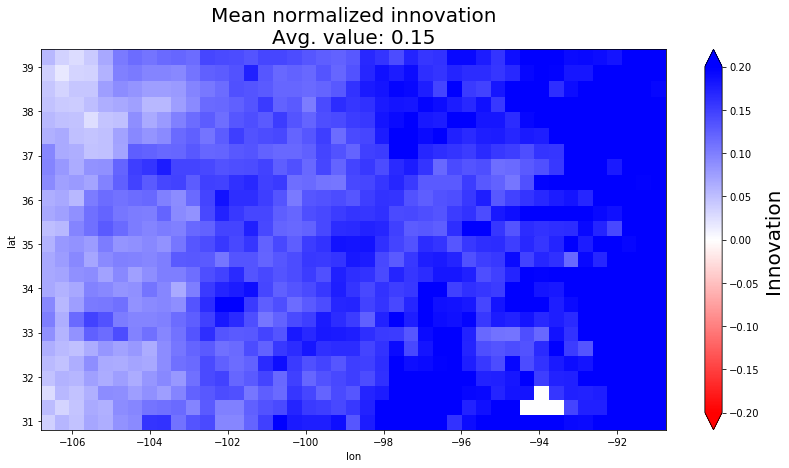

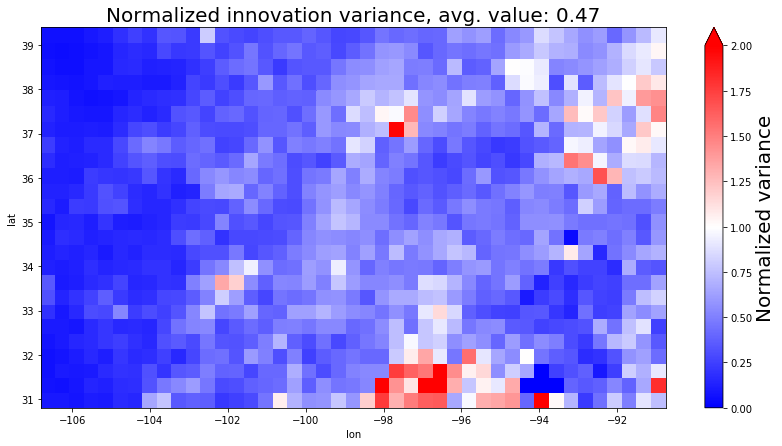

In [72]:
# ============================================================ #
# Plot innovation maps
# ============================================================ #
# --- Convert innovation to [time, lat, lon] --- #
da_innov = da_2D_to_3D_from_SMART(
                dict_array_2D={'innov': innov},
                da_mask=da_mask_smart,
                out_time_varname='time',
                out_time_coord=pd.date_range(start_time, end_time, freq='{}H'.format(time_step)))\
           ['innov']
# Remove -999 innovation values (for missing measurement time points)
innovation = da_innov.values
innovation[innovation==-999] = np.nan
da_innov[:] = innovation

# --- Plot --- #
# (1) Mean
da_innov_mean = da_innov.mean(dim='time')
fig = plt.figure(figsize=(14, 7))
cs = da_innov_mean.plot(add_colorbar=False, cmap='bwr_r', vmin=-0.2, vmax=0.2)
cbar = plt.colorbar(cs, extend='both').set_label('Innovation', fontsize=20)
plt.title('Mean normalized innovation\n'
          'Avg. value: {:.2f}'.format(float(da_innov_mean.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'innov_mean.png'), format='png',
            bbox_inches='tight')

# (2) Normalized variance
da_innov_var = da_innov.var(dim='time')
fig = plt.figure(figsize=(14, 7))
cs = da_innov_var.plot(add_colorbar=False, cmap='bwr', vmin=0, vmax=2)
cbar = plt.colorbar(cs, extend='max').set_label('Normalized variance', fontsize=20)
plt.title('Normalized innovation variance, '
          'avg. value: {:.2f}'.format(float(da_innov_var.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'innov_var_norm.png'), format='png',
            bbox_inches='tight', pad_inches=0)

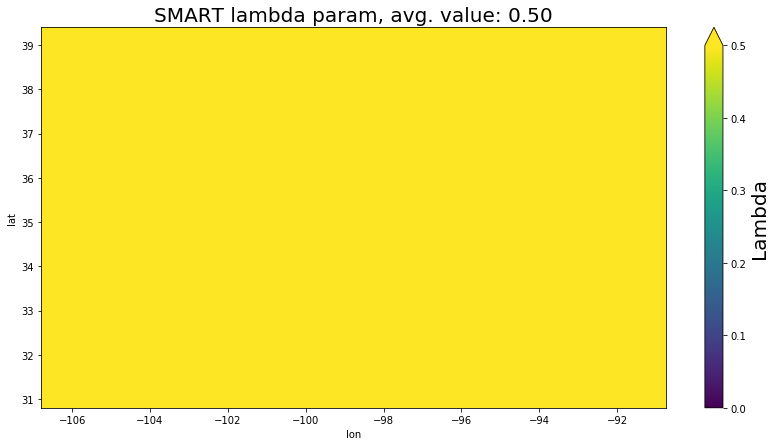

In [73]:
# ============================================================ #
# Plot lambda map
# ============================================================ #
# --- Convert lambda param to [lat, lon] --- #
da_lambda = da_2D_to_3D_from_SMART(
                dict_array_2D={'lambda': lambda_fraction},
                da_mask=da_mask_smart,
                out_time_varname='time',
                out_time_coord=['0'])['lambda'].sel(time='0')
# --- Lambda param map --- #
fig = plt.figure(figsize=(14, 7))
cs = da_lambda.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=0.5)
cbar = plt.colorbar(cs, extend='max').set_label('Lambda', fontsize=20)
plt.title('SMART lambda param, '
          'avg. value: {:.2f}'.format(float(da_lambda.mean().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'lambda_param.png'), format='png',
            bbox_inches='tight', pad_inches=0)

## Plot precipitation RMSE maps

In [74]:
# ============================================================ #
# Plot precipitation RMSE maps
# ============================================================ #
# --- Calculate RMSE --- #
# 3H
out_nc = os.path.join(output_subdir_data, 'rmse.orig.prec.3H.nc')
da_rmse_orig_3H = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3H', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.prec.3H.nc')
da_rmse_corrected_3H = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3H', log=False).where(da_mask)
# 1D
out_nc = os.path.join(output_subdir_data, 'rmse.orig.prec.1D.nc')
da_rmse_orig_1D = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='1D', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.prec.1D.nc')
da_rmse_corrected_1D = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='1D', log=False).where(da_mask)
# 3D
out_nc = os.path.join(output_subdir_data, 'rmse.orig.prec.3D.nc')
da_rmse_orig_3D = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3D', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.prec.3D.nc')
da_rmse_corrected_3D = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3D', log=False).where(da_mask)

# --- Calculate PER --- #
da_per_rmse_3H = (1 - da_rmse_corrected_3H / da_rmse_orig_3H) * 100
da_per_rmse_1D = (1 - da_rmse_corrected_1D / da_rmse_orig_1D) * 100
da_per_rmse_3D = (1 - da_rmse_corrected_3D / da_rmse_orig_3D) * 100

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


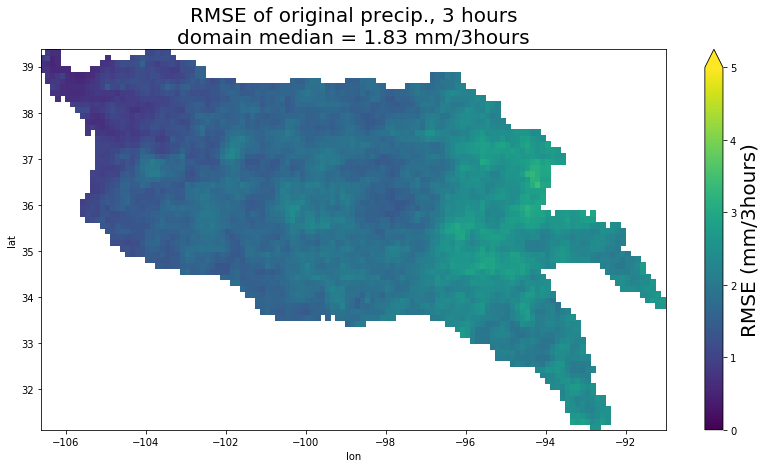

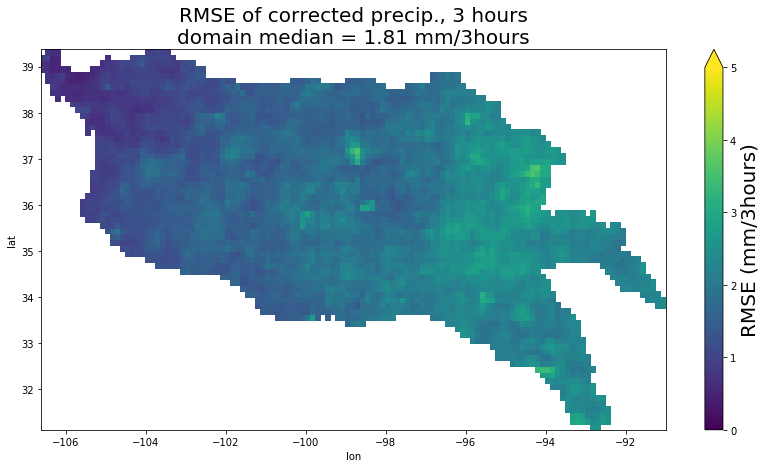

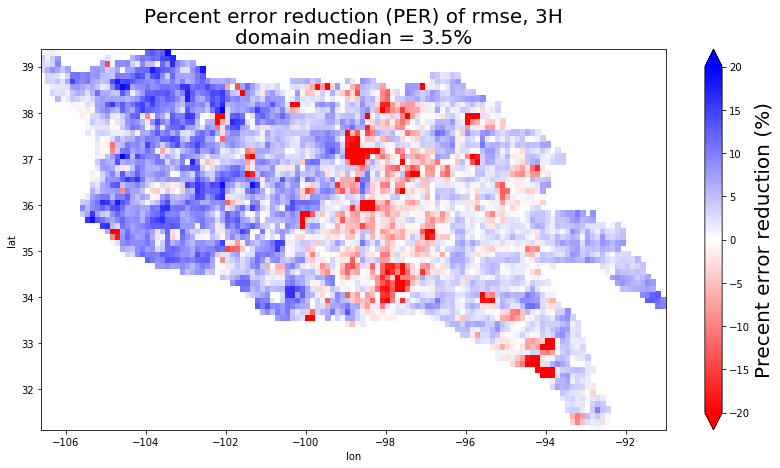

In [75]:
# --- Plot maps - 3 hourly --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/3hours)', fontsize=20)
plt.title('RMSE of original precip., 3 hours\n'
          'domain median = {:.2f} mm/3hours'.format(
              float(da_rmse_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/3hours)', fontsize=20)
plt.title('RMSE of corrected precip., 3 hours\n'
          'domain median = {:.2f} mm/3hours'.format(
              float(da_rmse_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmse_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-20, vmax=20)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmse, 3H\n'
          'domain median = {:.1f}%'.format(da_per_rmse_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmse.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

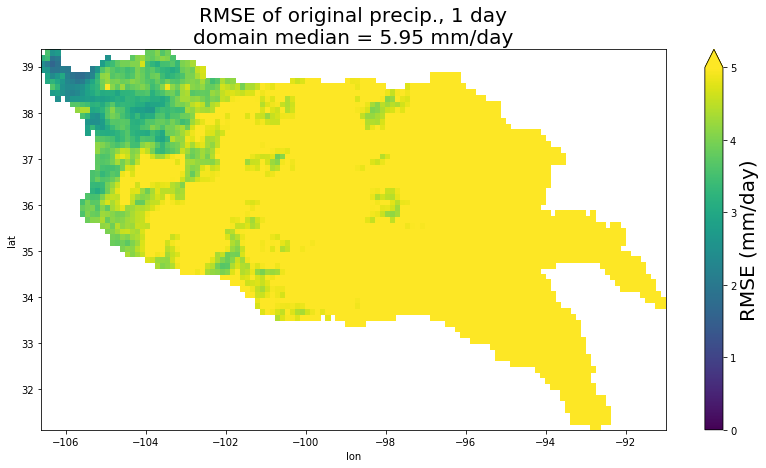

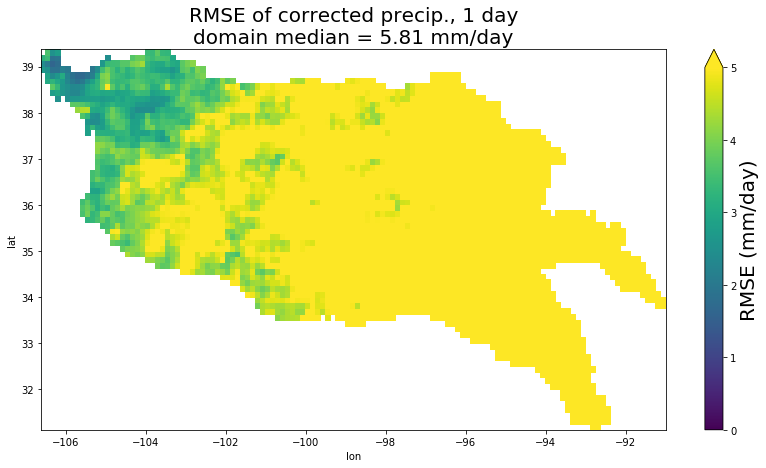

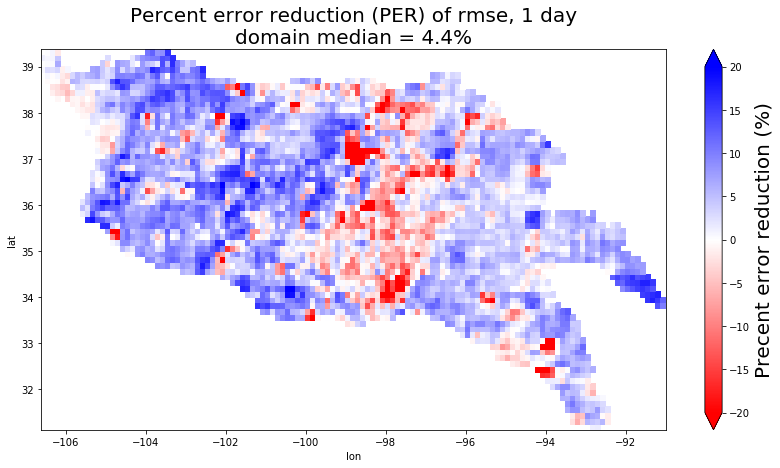

In [76]:
# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_orig_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of original precip., 1 day\n'
          'domain median = {:.2f} mm/day'.format(
              float(da_rmse_orig_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_orig.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_corrected_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of corrected precip., 1 day\n'
          'domain median = {:.2f} mm/day'.format(
              float(da_rmse_corrected_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_corrected.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmse_1D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-20, vmax=20)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmse, 1 day\n'
          'domain median = {:.1f}%'.format(da_per_rmse_1D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmse.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

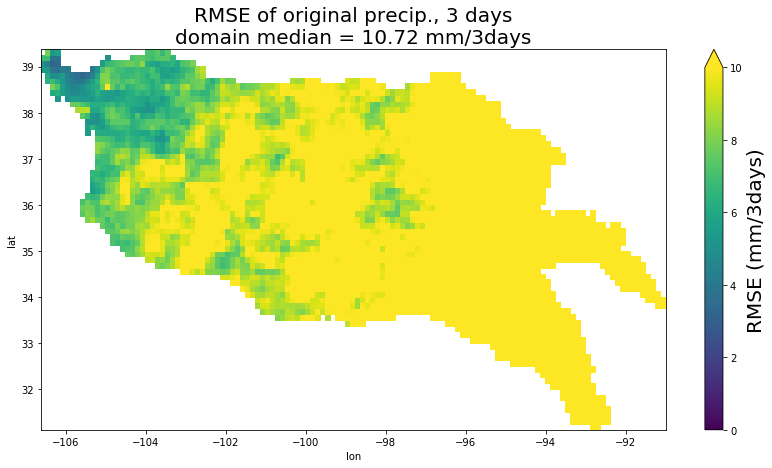

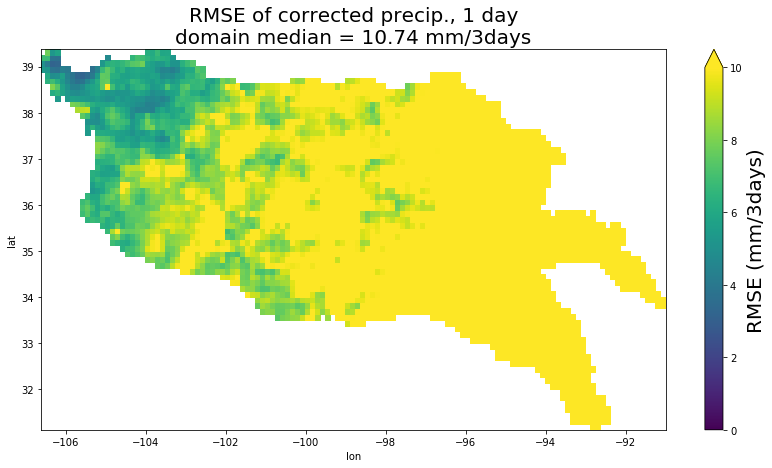

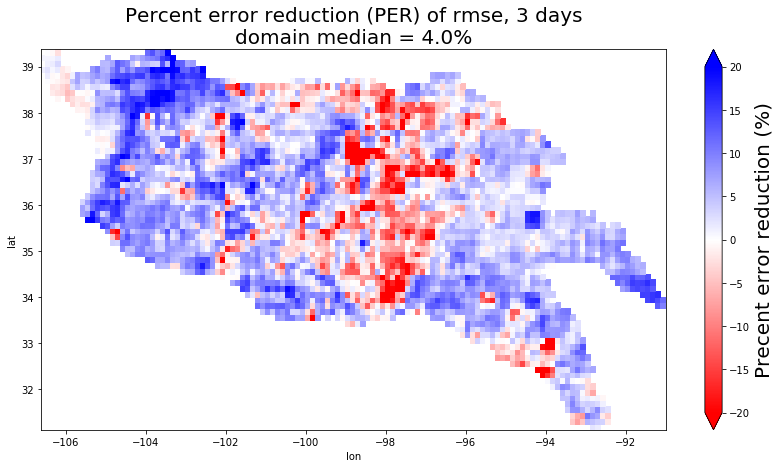

In [77]:
# --- Plot maps - 3 days --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_orig_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=10)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/3days)', fontsize=20)
plt.title('RMSE of original precip., 3 days\n'
          'domain median = {:.2f} mm/3days'.format(
              float(da_rmse_orig_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_orig.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_corrected_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=10)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/3days)', fontsize=20)
plt.title('RMSE of corrected precip., 1 day\n'
          'domain median = {:.2f} mm/3days'.format(
              float(da_rmse_corrected_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmse.prec_corrected.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmse_3D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-20, vmax=20)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmse, 3 days\n'
          'domain median = {:.1f}%'.format(da_per_rmse_3D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmse.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

## Plot precipitation RMSE_log maps

In [78]:
# ============================================================ #
# Plot precipitation RMSE_log maps
# ============================================================ #
# --- Calculate RMSE_log --- #
# 3H
out_nc = os.path.join(output_subdir_data, 'rmse.orig.logPrec.3H.nc')
da_rmseLog_orig_3H = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3H', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.logPrec.3H.nc')
da_rmseLog_corrected_3H = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3H', log=True).where(da_mask)
# 1D
out_nc = os.path.join(output_subdir_data, 'rmse.orig.logPrec.1D.nc')
da_rmseLog_orig_1D = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='1D', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.logPrec.1D.nc')
da_rmseLog_corrected_1D = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='1D', log=True).where(da_mask)
# 3D
out_nc = os.path.join(output_subdir_data, 'rmse.orig.logPrec.3D.nc')
da_rmseLog_orig_3D = calculate_rmse_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3D', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'rmse.corrected.logPrec.3D.nc')
da_rmseLog_corrected_3D = calculate_rmse_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3D', log=True).where(da_mask)

# --- Calculate PER --- #
da_per_rmseLog_3H = (1 - da_rmseLog_corrected_3H / da_rmseLog_orig_3H) * 100
da_per_rmseLog_1D = (1 - da_rmseLog_corrected_1D / da_rmseLog_orig_1D) * 100
da_per_rmseLog_3D = (1 - da_rmseLog_corrected_3D / da_rmseLog_orig_3D) * 100

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


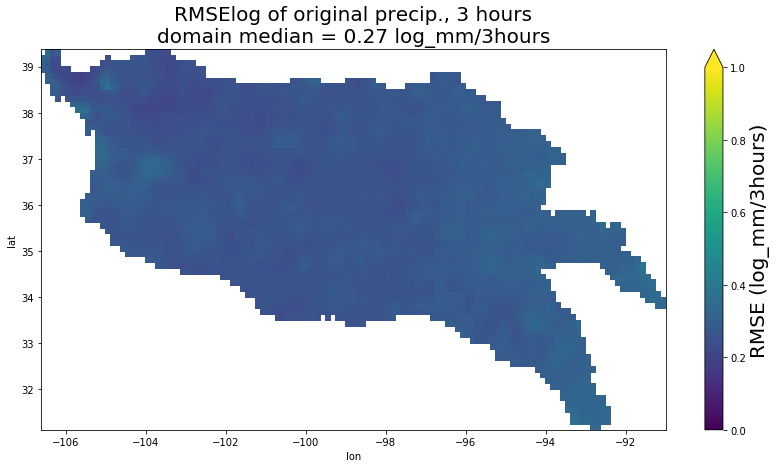

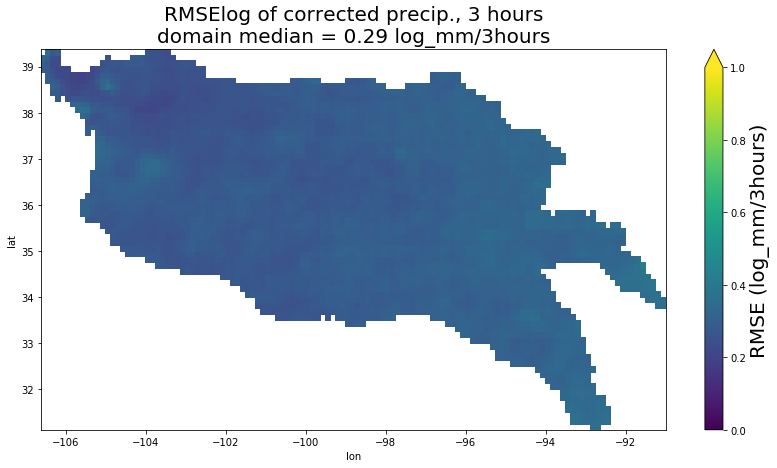

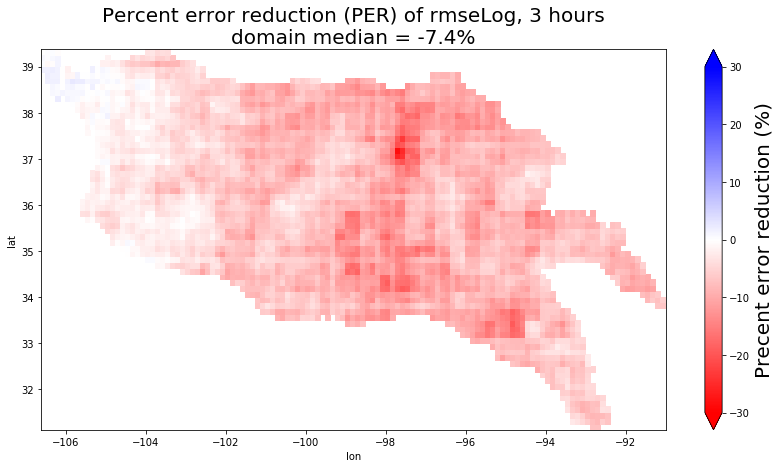

In [79]:
# --- Plot maps - 3 hours --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/3hours)', fontsize=20)
plt.title('RMSElog of original precip., 3 hours\n'
          'domain median = {:.2f} log_mm/3hours'.format(
              float(da_rmseLog_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/3hours)', fontsize=20)
plt.title('RMSElog of corrected precip., 3 hours\n'
          'domain median = {:.2f} log_mm/3hours'.format(
              float(da_rmseLog_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmseLog_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-30, vmax=30)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmseLog, 3 hours\n'
          'domain median = {:.1f}%'.format(da_per_rmseLog_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmseLog.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

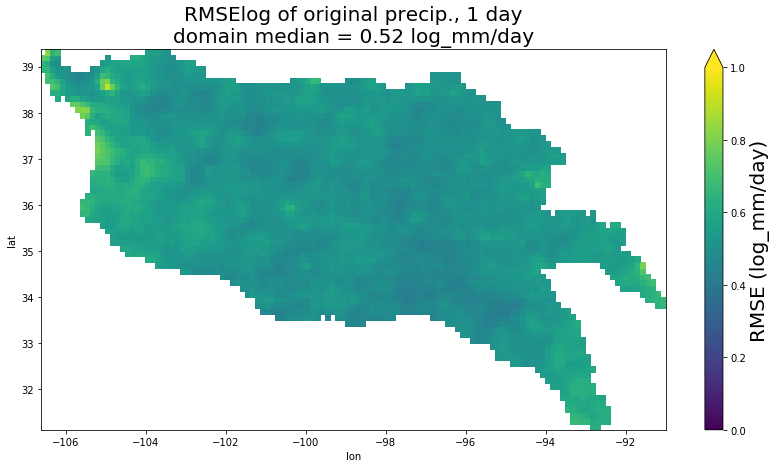

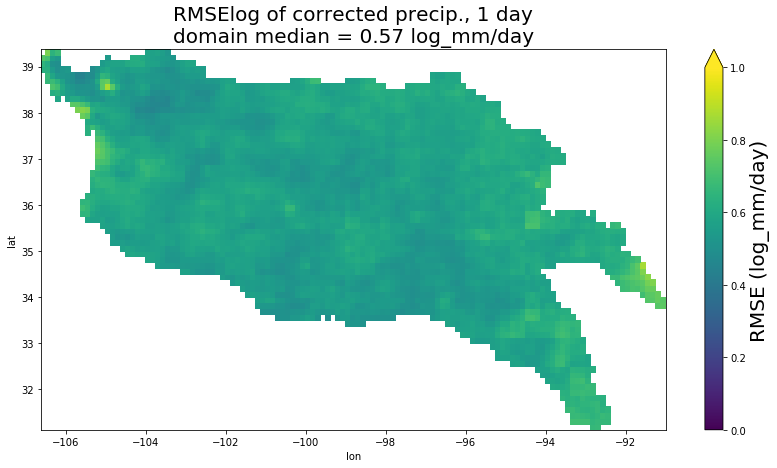

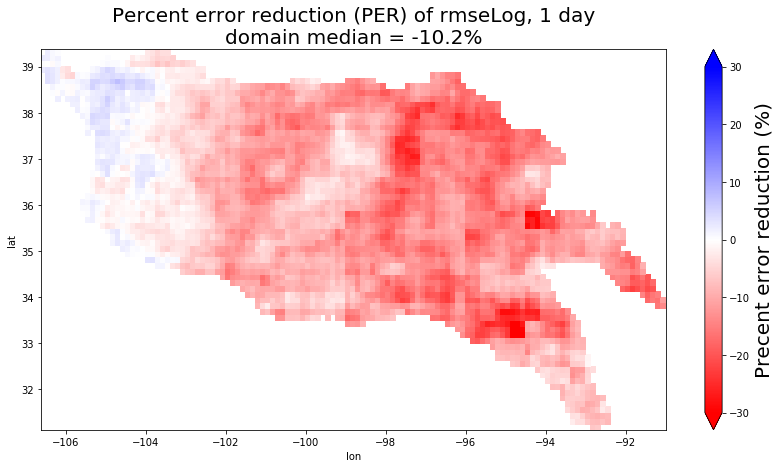

In [80]:
# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_orig_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/day)', fontsize=20)
plt.title('RMSElog of original precip., 1 day\n'
          'domain median = {:.2f} log_mm/day'.format(
              float(da_rmseLog_orig_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_orig.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_corrected_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/day)', fontsize=20)
plt.title('RMSElog of corrected precip., 1 day\n'
          'domain median = {:.2f} log_mm/day'.format(
              float(da_rmseLog_corrected_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_corrected.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmseLog_1D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-30, vmax=30)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmseLog, 1 day\n'
          'domain median = {:.1f}%'.format(da_per_rmseLog_1D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmseLog.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

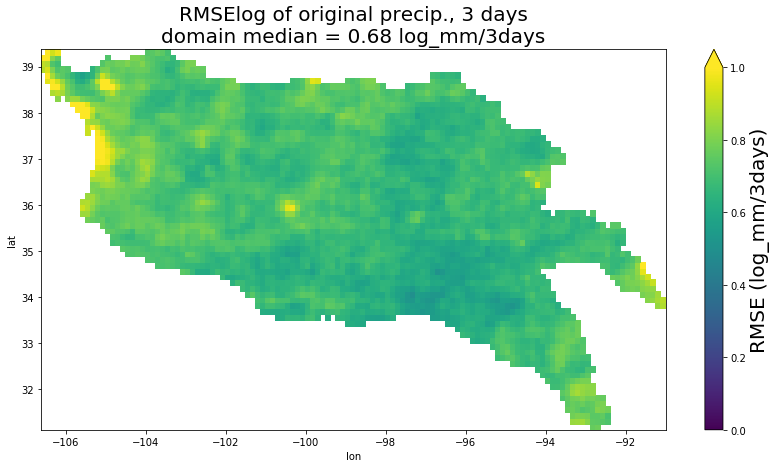

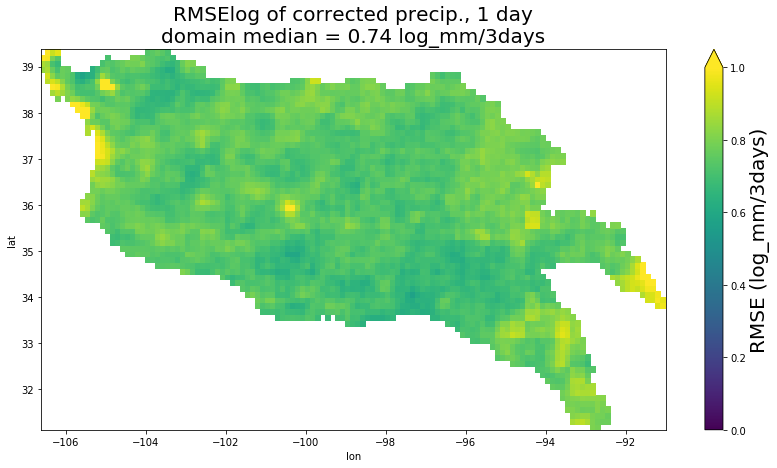

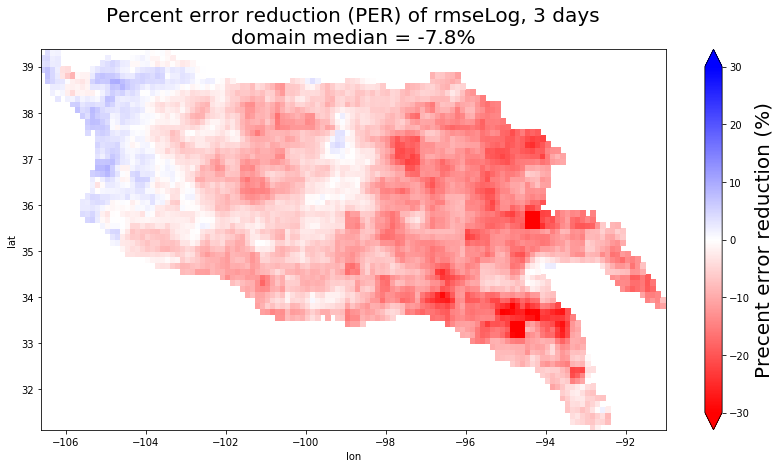

In [81]:
# --- Plot maps - 3 days --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_orig_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/3days)', fontsize=20)
plt.title('RMSElog of original precip., 3 days\n'
          'domain median = {:.2f} log_mm/3days'.format(
              float(da_rmseLog_orig_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_orig.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_rmseLog_corrected_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (log_mm/3days)', fontsize=20)
plt.title('RMSElog of corrected precip., 1 day\n'
          'domain median = {:.2f} log_mm/3days'.format(
              float(da_rmseLog_corrected_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'rmseLog.prec_corrected.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_per_rmseLog_3D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-30, vmax=30)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction (%)', fontsize=20)
plt.title('Percent error reduction (PER) of rmseLog, 3 days\n'
          'domain median = {:.1f}%'.format(da_per_rmseLog_3D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.rmseLog.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

## Plot precipitation correlation maps

In [82]:
# ============================================================ #
# Plot precipitation correlation maps
# ============================================================ #
# --- Calculate corrcoef --- #
# 3H
out_nc = os.path.join(output_subdir_data, 'corrcoef.orig.prec.3H.nc')
da_corrcoef_orig_3H = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3H', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoef.corrected.prec.3H.nc')
da_corrcoef_corrected_3H = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3H', log=False).where(da_mask)
# 1D
out_nc = os.path.join(output_subdir_data, 'corrcoef.orig.prec.1D.nc')
da_corrcoef_orig_1D = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='1D', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoef.corrected.prec.1D.nc')
da_corrcoef_corrected_1D = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='1D', log=False).where(da_mask)
# 3D
out_nc = os.path.join(output_subdir_data, 'corrcoef.orig.prec.3D.nc')
da_corrcoef_orig_3D = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3D', log=False).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoef.corrected.prec.3D.nc')
da_corrcoef_corrected_3D = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3D', log=False).where(da_mask)

# --- Calculate absolute improvement of corrcoef --- #
da_corrcoef_improv_3H = da_corrcoef_corrected_3H - da_corrcoef_orig_3H
da_corrcoef_improv_1D = da_corrcoef_corrected_1D - da_corrcoef_orig_1D
da_corrcoef_improv_3D = da_corrcoef_corrected_3D - da_corrcoef_orig_3D

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


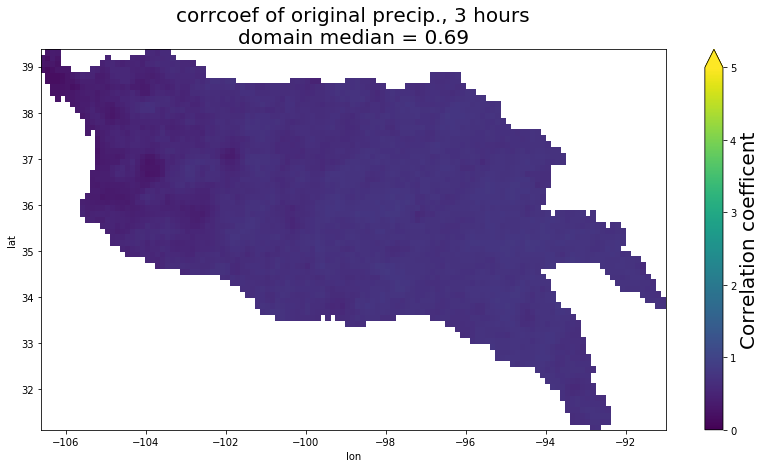

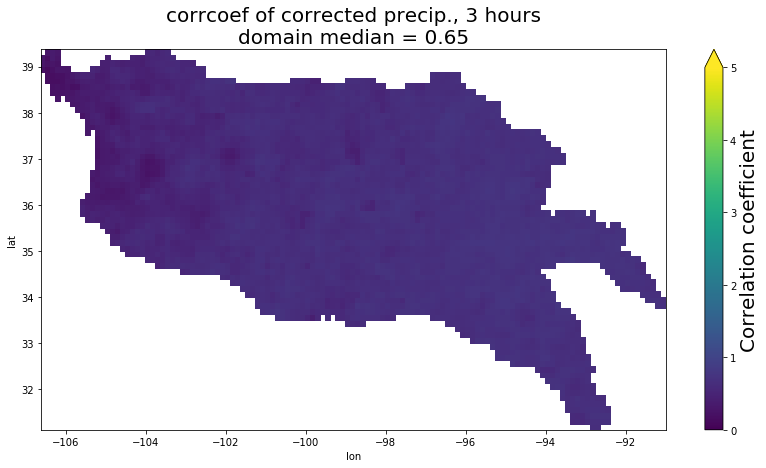

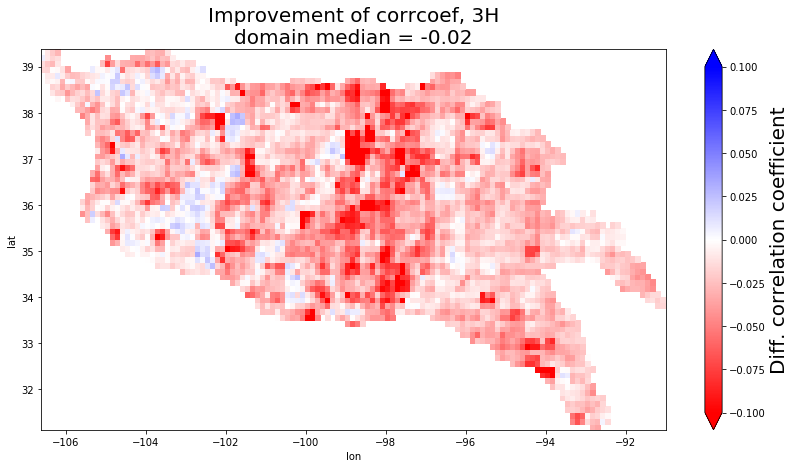

In [83]:
# --- Plot maps - 3 hourly --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoef of original precip., 3 hours\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoef of corrected precip., 3 hours\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_improv_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoef, 3H\n'
          'domain median = {:.2f}'.format(da_corrcoef_improv_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.improv.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

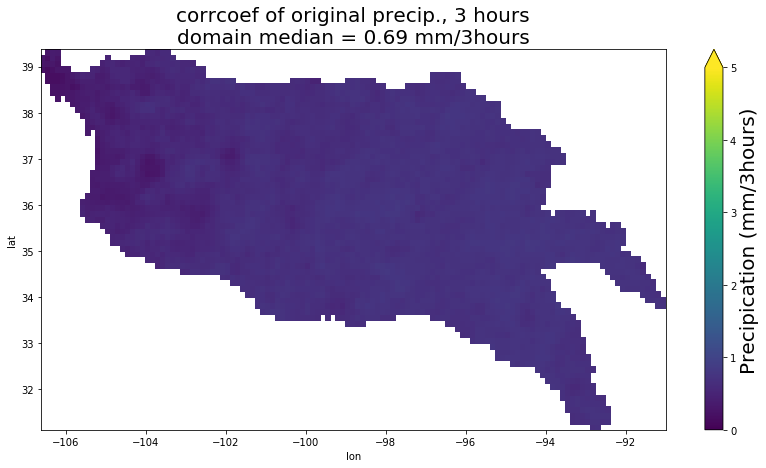

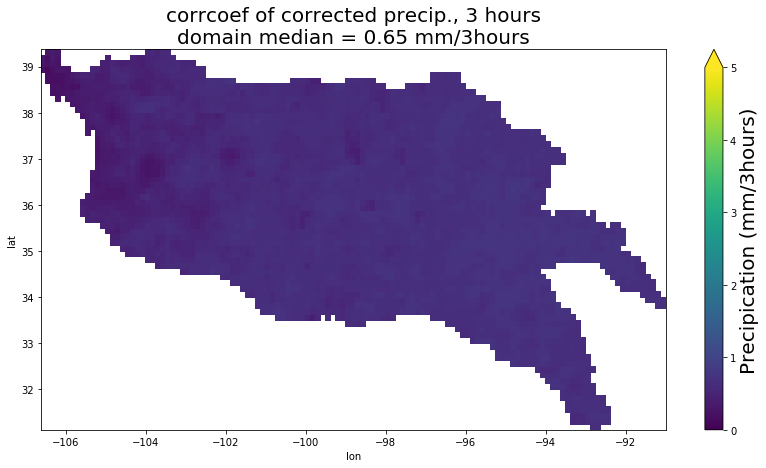

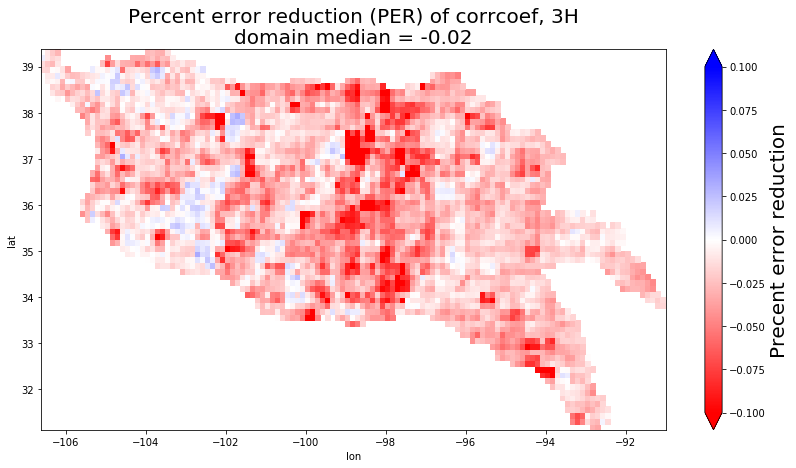

In [84]:
# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Precipication (mm/3hours)', fontsize=20)
plt.title('corrcoef of original precip., 3 hours\n'
          'domain median = {:.2f} mm/3hours'.format(
              float(da_corrcoef_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Precipication (mm/3hours)', fontsize=20)
plt.title('corrcoef of corrected precip., 3 hours\n'
          'domain median = {:.2f} mm/3hours'.format(
              float(da_corrcoef_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# PER
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_improv_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Precent error reduction', fontsize=20)
plt.title('Percent error reduction (PER) of corrcoef, 3H\n'
          'domain median = {:.2f}'.format(da_corrcoef_improv_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'per.corrcoefLog.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

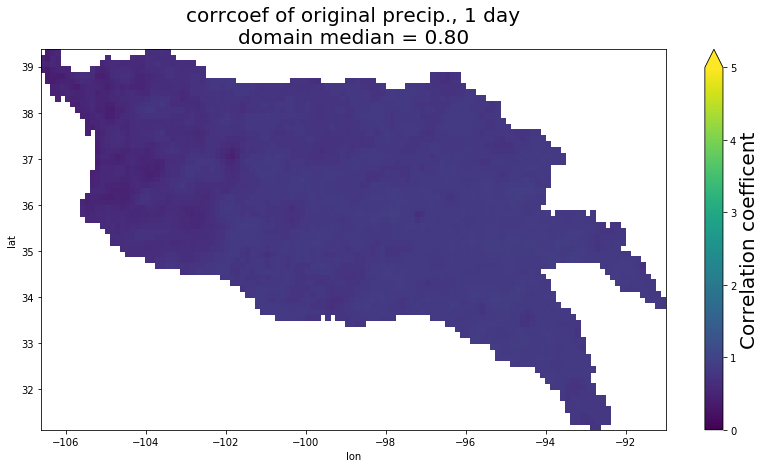

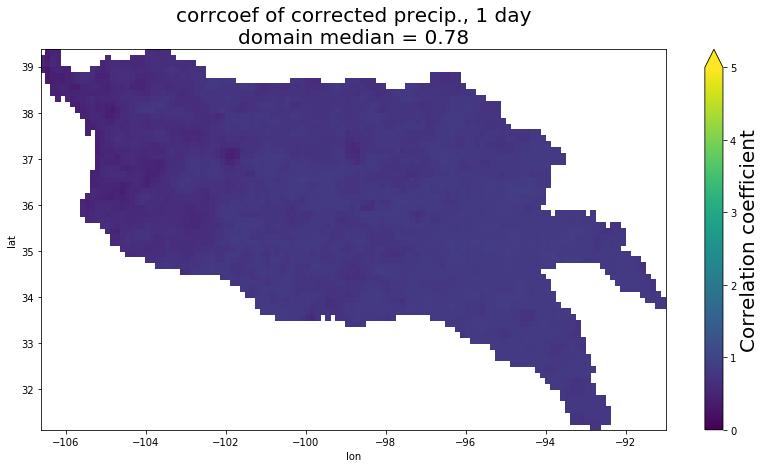

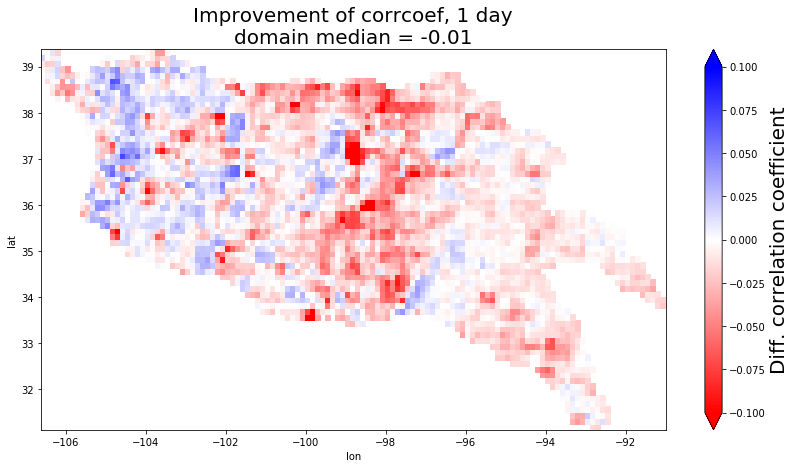

In [85]:
# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_orig_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoef of original precip., 1 day\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_orig_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_orig.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_corrected_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoef of corrected precip., 1 day\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_corrected_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_corrected.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_improv_1D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoef, 1 day\n'
          'domain median = {:.2f}'.format(da_corrcoef_improv_1D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.improv.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

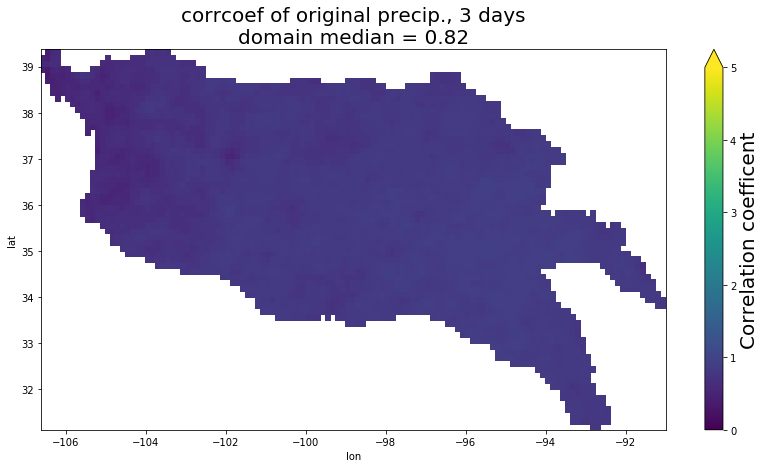

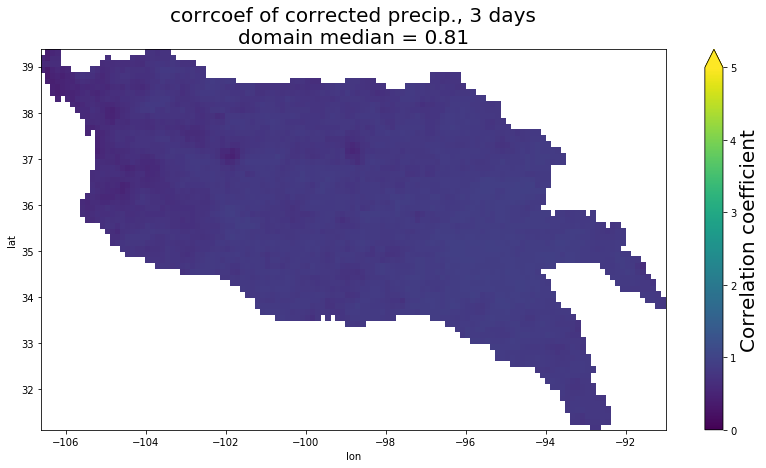

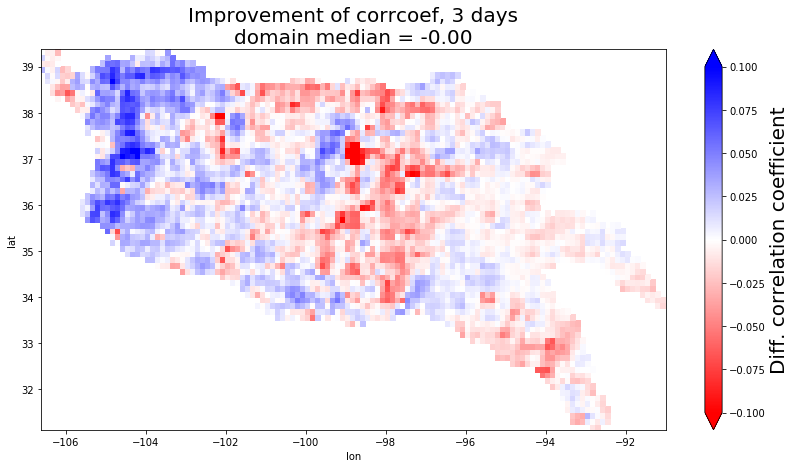

In [86]:
# --- Plot maps - 3 days --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_orig_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoef of original precip., 3 days\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_orig_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_orig.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_corrected_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoef of corrected precip., 3 days\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoef_corrected_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.prec_corrected.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoef_improv_3D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoef, 3 days\n'
          'domain median = {:.2f}'.format(da_corrcoef_improv_3D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoef.improv.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

## Plot log_precipitation correlation maps

In [87]:
# ============================================================ #
# Plot log_precipitation correlation maps
# ============================================================ #
# --- Calculate corrcoefLog --- #
# 3H
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.orig.prec.3H.nc')
da_corrcoefLog_orig_3H = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3H', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.corrected.prec.3H.nc')
da_corrcoefLog_corrected_3H = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3H', log=True).where(da_mask)
# 1D
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.orig.prec.1D.nc')
da_corrcoefLog_orig_1D = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='1D', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.corrected.prec.1D.nc')
da_corrcoefLog_corrected_1D = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='1D', log=True).where(da_mask)
# 3D
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.orig.prec.3D.nc')
da_corrcoefLog_orig_3D = calculate_corrcoef_prec(
    out_nc, da_prec_orig, da_prec_truth,
    agg_freq='3D', log=True).where(da_mask)
out_nc = os.path.join(output_subdir_data, 'corrcoefLog.corrected.prec.3D.nc')
da_corrcoefLog_corrected_3D = calculate_corrcoef_prec(
    out_nc, da_prec_corrected, da_prec_truth,
    agg_freq='3D', log=True).where(da_mask)

# --- Calculate absolute improvement of corrcoefLog --- #
da_corrcoefLog_improv_3H = da_corrcoefLog_corrected_3H - da_corrcoefLog_orig_3H
da_corrcoefLog_improv_1D = da_corrcoefLog_corrected_1D - da_corrcoefLog_orig_1D
da_corrcoefLog_improv_3D = da_corrcoefLog_corrected_3D - da_corrcoefLog_orig_3D

/civil/hydro/ymao/anaconda3/envs/da2/lib/python3.5/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


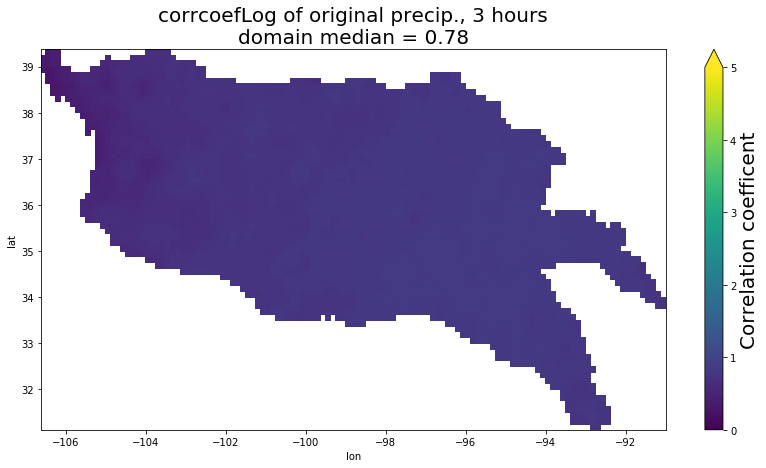

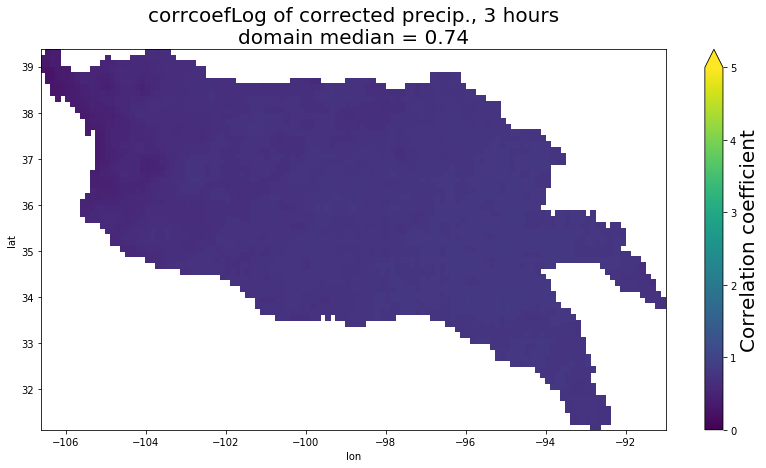

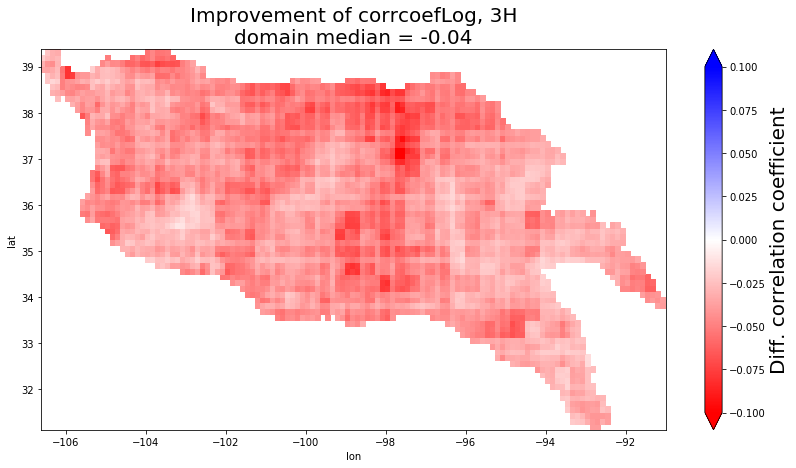

In [88]:
# --- Plot maps - 3 hourly --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_orig_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoefLog of original precip., 3 hours\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_orig_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_orig.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_corrected_3H.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoefLog of corrected precip., 3 hours\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_corrected_3H.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_corrected.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_improv_3H.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoefLog, 3H\n'
          'domain median = {:.2f}'.format(da_corrcoefLog_improv_3H.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.improv.3H.png'), format='png',
            bbox_inches='tight', pad_inches=0)

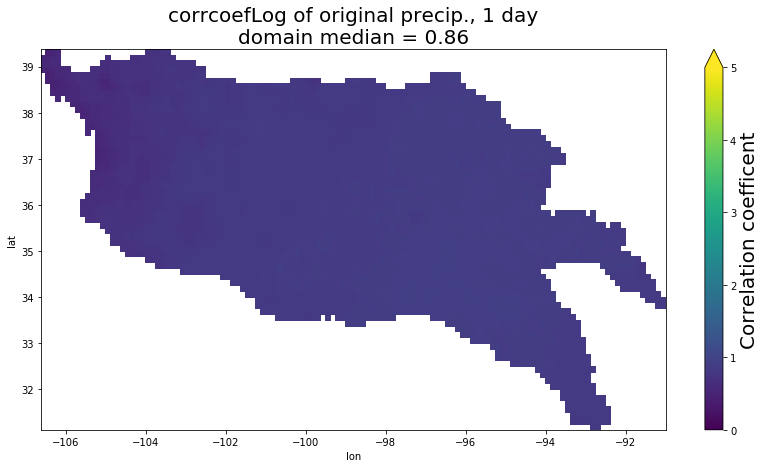

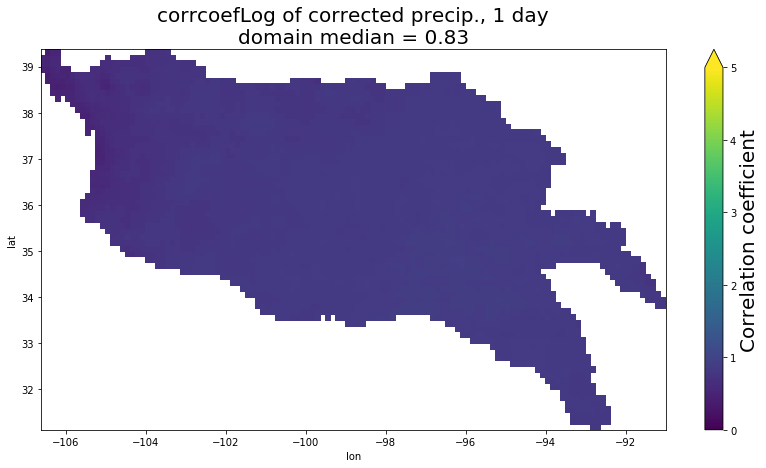

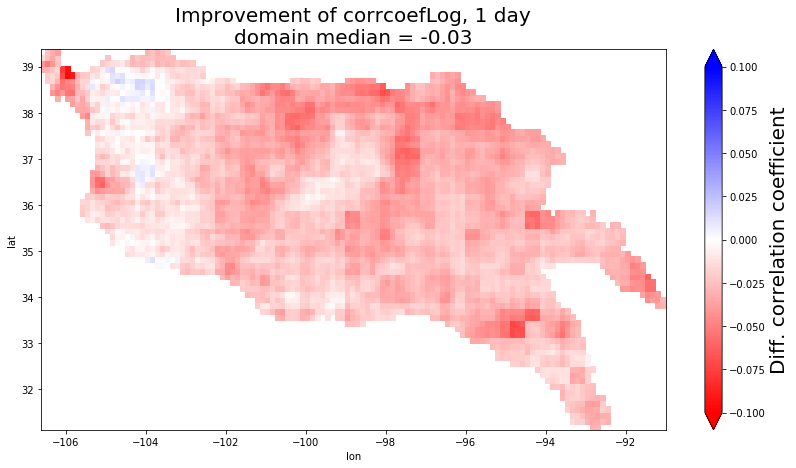

In [89]:
# --- Plot maps - 1 day --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_orig_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoefLog of original precip., 1 day\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_orig_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_orig.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_corrected_1D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoefLog of corrected precip., 1 day\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_corrected_1D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_corrected.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_improv_1D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoefLog, 1 day\n'
          'domain median = {:.2f}'.format(da_corrcoefLog_improv_1D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.improv.1D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

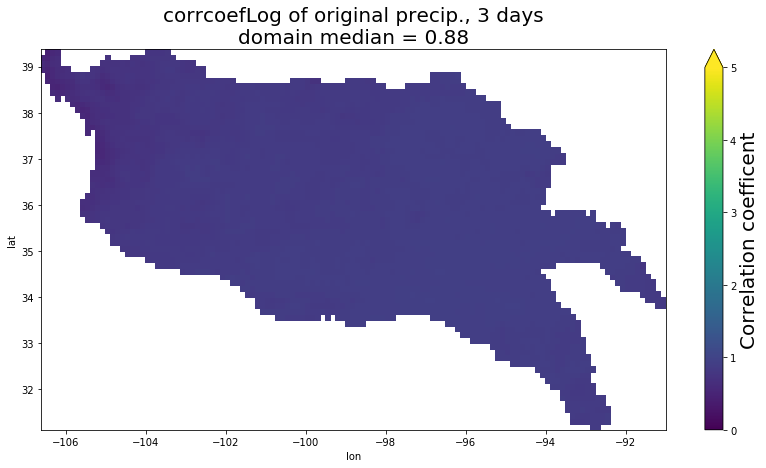

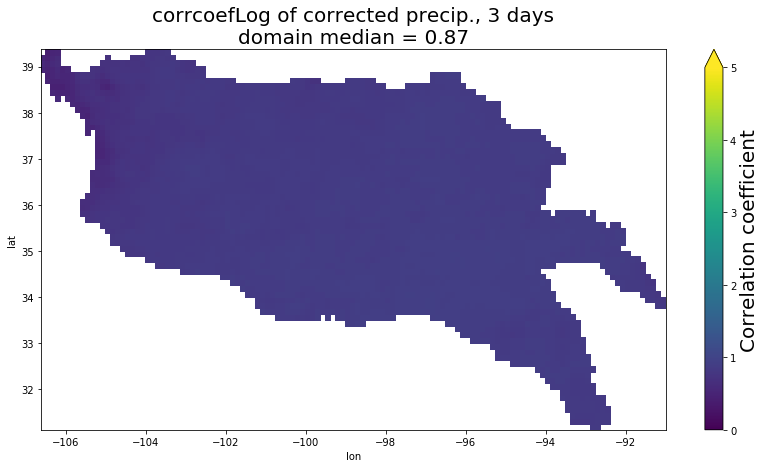

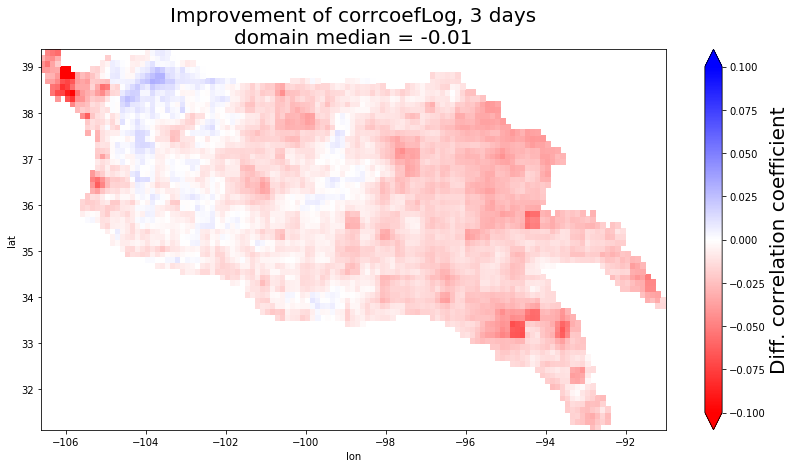

In [90]:
# --- Plot maps - 3 days --- #
# Orig. precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_orig_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficent', fontsize=20)
plt.title('corrcoefLog of original precip., 3 days\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_orig_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_orig.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Corrected precipitation
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_corrected_3D.plot(add_colorbar=False, cmap='viridis', vmin=0, vmax=5)
cbar = plt.colorbar(cs, extend='max').set_label('Correlation coefficient', fontsize=20)
plt.title('corrcoefLog of corrected precip., 3 days\n'
          'domain median = {:.2f}'.format(
              float(da_corrcoefLog_corrected_3D.median().values)), fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.prec_corrected.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Diff
fig = plt.figure(figsize=(14, 7))
cs = da_corrcoefLog_improv_3D.plot(
    add_colorbar=False, cmap='bwr_r', vmin=-0.1, vmax=0.1)
cbar = plt.colorbar(cs, extend='both').set_label('Diff. correlation coefficient', fontsize=20)
plt.title('Improvement of corrcoefLog, 3 days\n'
          'domain median = {:.2f}'.format(da_corrcoefLog_improv_3D.median().values),
          fontsize=20)
fig.savefig(os.path.join(output_subdir_maps, 'corrcoefLog.improv.3D.png'), format='png',
            bbox_inches='tight', pad_inches=0)

# Time series

In [95]:
lat = 34.6875
lon = -94.9375

In [97]:
# --- Extract grid cell results --- #
ts_orig = da_prec_orig.sel(lat=lat, lon=lon).to_series()
ts_truth = da_prec_truth.sel(lat=lat, lon=lon).to_series()
ts_corrected = da_prec_corrected.sel(lat=lat, lon=lon).to_series()

(396600, 397320)

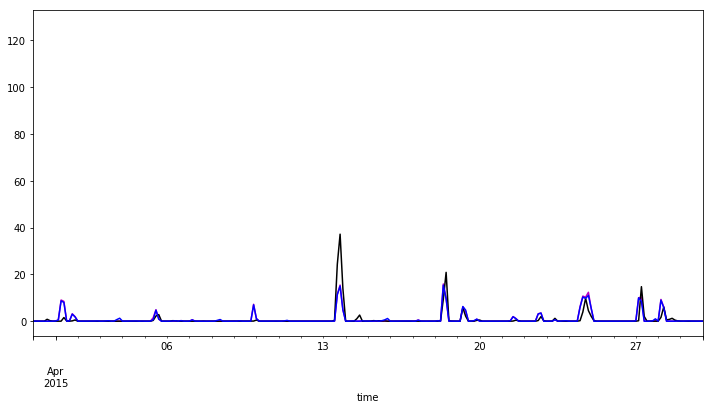

In [104]:
# --- Plot - 3H --- #
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()
# Plot orig
ts_orig.plot(color='m', style='-',
             label='Open-loop', legend=False)
# Plot truth
ts_truth.plot(color='k', style='-',
              label='Truth', legend=False)
# Plot corrected
ts_corrected.plot(color='b', style='-',
                  label='SMART-corrected', legend=False)
plt.xlim(['2015-03-31', '2015-04-30'])

# Functions

In [91]:
def calculate_rmse_prec(out_nc, da_truth, da_model,
                        agg_freq, log):
    ''' A wrap funciton that calculates RMSE for all domain and save to file; if
        result file already existed, then simply read in the file.

    Parameters
    ----------
    out_nc: <str>
        RMSE result output netCDF file
    da_truth: <xr.Dataset>
        Truth precip
    da_model: <xr.Dataset>
        Corrected prec whose RMSE is to be assessed (wrt. truth)
    agg_freq: <str>
        Aggregation frequency for rmse calculation;
        e.g., '3H', '3D'
    log: <bool>
        Whether to take log first before calculating RMSE (but after aggregating)
    '''

    if not os.path.isfile(out_nc):  # if RMSE is not already calculated
        # --- Aggregate --- #
        da_truth_agg = da_truth.resample(dim='time', how='sum', freq=agg_freq)
        da_model_agg = da_model.resample(dim='time', how='sum', freq=agg_freq)
        # --- Take log if specified --- #
        if log is True:
            da_truth_agg = np.log(da_truth_agg + 1)
            da_model_agg = np.log(da_model_agg + 1)
        # --- Calculate RMSE --- #
        # Determine the total number of loops
        lat_coord = da_truth['lat']
        lon_coord = da_truth['lon']
        nloop = len(lat_coord) * len(lon_coord)
        # Reshape variables
        truth = da_truth_agg.values.reshape(
            [len(da_truth_agg['time']), nloop])  # [time, nloop]
        model = da_model_agg.values.reshape(
            [len(da_model_agg['time']), nloop])  # [time, nloop]
        # Calculate RMSE for all grid cells
        rmse_model = np.array(list(map(
                     lambda j: rmse(truth[:, j], model[:, j]),
                    range(nloop))))  # [nloop]
        # Reshape RMSE's
        rmse_model = rmse_model.reshape(
            [len(lat_coord), len(lon_coord)])  # [lat, lon]
        # Put results into da's
        da_rmse_model = xr.DataArray(
            rmse_model, coords=[lat_coord, lon_coord],
            dims=['lat', 'lon'])  # [mm/mm]
        # Save RMSE to netCDF file
        ds_rmse_model = xr.Dataset(
            {'rmse': da_rmse_model})
        ds_rmse_model.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
    else:  # if RMSE is already calculated
        da_rmse_model = xr.open_dataset(out_nc)['rmse']

    return da_rmse_model

In [92]:
def calculate_corrcoef_prec(out_nc, da_truth, da_model,
                            agg_freq, log):
    ''' A wrap funciton that calculates corrcoef for all domain and save to file; if
        result file already existed, then simply read in the file.

    Parameters
    ----------
    out_nc: <str>
        corrcoef result output netCDF file
    da_truth: <xr.Dataset>
        Truth precip
    da_model: <xr.Dataset>
        Corrected prec whose corrcoef is to be assessed (wrt. truth)
    agg_freq: <str>
        Aggregation frequency for corrcoef calculation;
        e.g., '3H', '3D'
    log: <bool>
        Whether to take log first before calculating corrcoef (but after aggregating)
    '''

    if not os.path.isfile(out_nc):  # if corrcoef is not already calculated
        # --- Aggregate --- #
        da_truth_agg = da_truth.resample(dim='time', how='sum', freq=agg_freq)
        da_model_agg = da_model.resample(dim='time', how='sum', freq=agg_freq)
        # --- Take log if specified --- #
        if log is True:
            da_truth_agg = np.log(da_truth_agg + 1)
            da_model_agg = np.log(da_model_agg + 1)
        # --- Calculate corrcoef --- #
        # Determine the total number of loops
        lat_coord = da_truth['lat']
        lon_coord = da_truth['lon']
        nloop = len(lat_coord) * len(lon_coord)
        # Reshape variables
        truth = da_truth_agg.values.reshape(
            [len(da_truth_agg['time']), nloop])  # [time, nloop]
        model = da_model_agg.values.reshape(
            [len(da_model_agg['time']), nloop])  # [time, nloop]
        # Calculate corrcoef for all grid cells
        corrcoef_model = np.array(list(map(
                     lambda j: np.corrcoef(truth[:, j], model[:, j])[0, 1],
                    range(nloop))))  # [nloop]
        # Reshape corrcoef's
        corrcoef_model = corrcoef_model.reshape(
            [len(lat_coord), len(lon_coord)])  # [lat, lon]
        # Put results into da's
        da_corrcoef_model = xr.DataArray(
            corrcoef_model, coords=[lat_coord, lon_coord],
            dims=['lat', 'lon'])  # [mm/mm]
        # Save corrcoef to netCDF file
        ds_corrcoef_model = xr.Dataset(
            {'corrcoef': da_corrcoef_model})
        ds_corrcoef_model.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
    else:  # if corrcoef is already calculated
        da_corrcoef_model = xr.open_dataset(out_nc)['corrcoef']

    return da_corrcoef_model